# Retrieval

Retrieval is the centerpiece of our retrieval augmented generation (RAG) flow. 

Let's get our vectorDB from before.


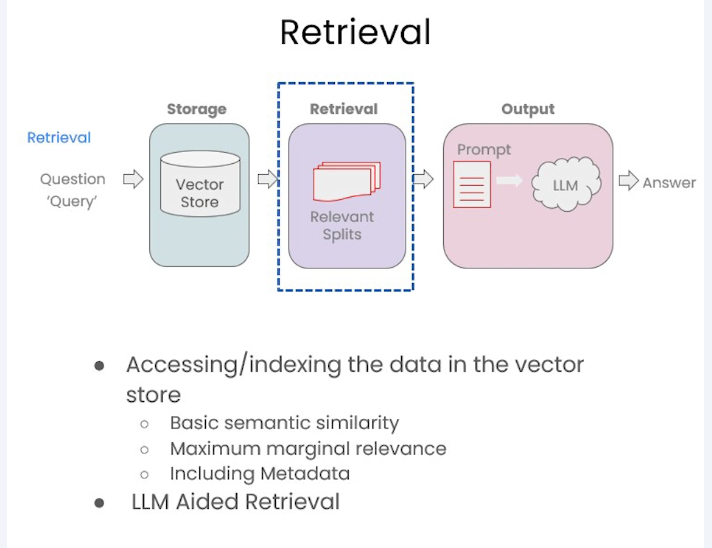

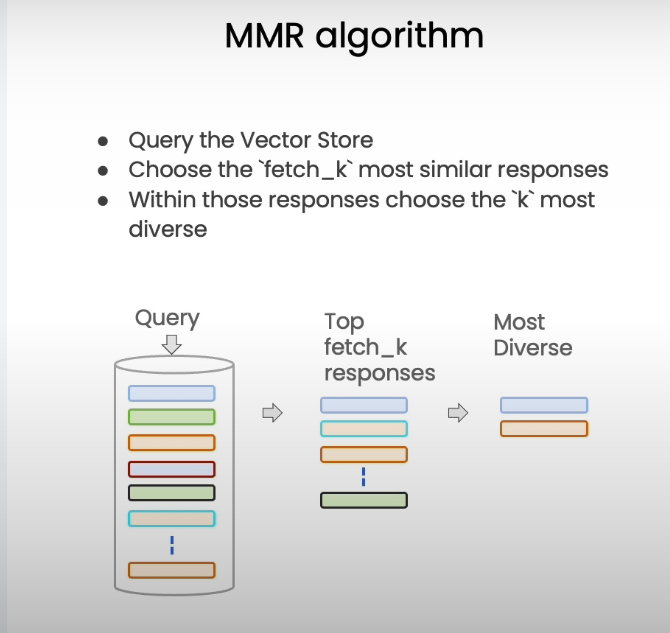

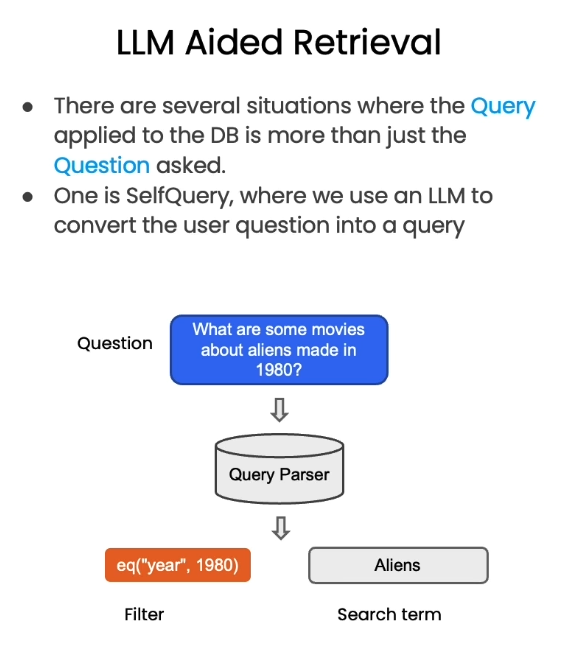

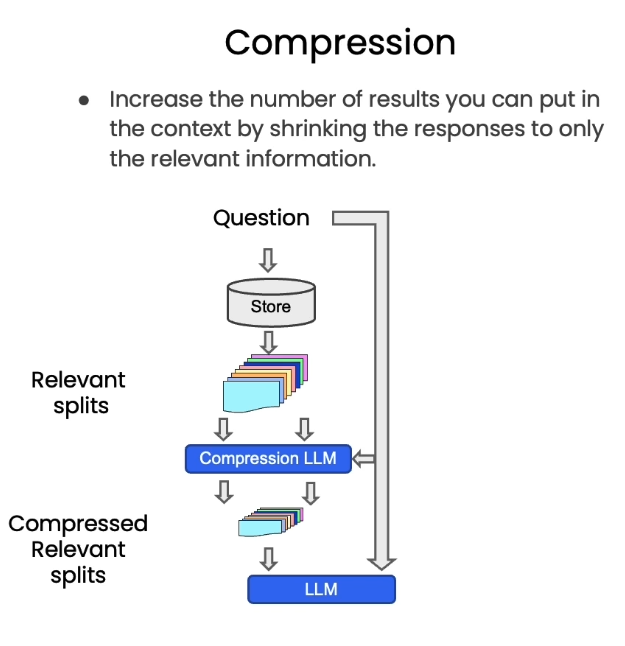

In [ ]:
import os
from dotenv import load_dotenv

from langchain_community.document_loaders import PyPDFLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.embeddings import HuggingFaceEmbeddings
from langchain_community.vectorstores import Chroma

In [39]:
load_dotenv()
api_key = os.getenv("GROQ_API_KEY")

In [3]:
# Load PDF
loaders = [
    # Duplicate documents on purpose - messy data
    PyPDFLoader("Data/MachineLearning-Lecture01 (Copy).pdf"),
    PyPDFLoader("Data/DeepSeek_R1.pdf"),
    PyPDFLoader("Data/Kolmogorov–Arnold Transformer.pdf"),
    PyPDFLoader("Data/MachineLearning-Lecture01.pdf")
]
docs = []
for loader in loaders:
    docs.extend(loader.load())

In [4]:
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size = 1500,
    chunk_overlap = 150
)

In [5]:
splits = text_splitter.split_documents(docs)

In [6]:
model_name = 'sentence-transformers/all-MiniLM-L6-v2'
embeddings= HuggingFaceEmbeddings(model_name = model_name)

/tmp/ipykernel_229048/2774317636.py:2: LangChainDeprecationWarning: The class `HuggingFaceEmbeddings` was deprecated in LangChain 0.2.2 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-huggingface package and should be used instead. To use it run `pip install -U :class:`~langchain-huggingface` and import as `from :class:`~langchain_huggingface import HuggingFaceEmbeddings``.
  embeddings= HuggingFaceEmbeddings(model_name = model_name)
2025-03-22 19:42:28.266539: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1742650948.377168  229048 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1742650948.419711  229048 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugi

In [7]:
persist_directory = 'docs/chroma/'

In [8]:
vectordb = Chroma(
    persist_directory=persist_directory,
    embedding_function=embeddings
)

/tmp/ipykernel_229048/774848044.py:1: LangChainDeprecationWarning: The class `Chroma` was deprecated in LangChain 0.2.9 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-chroma package and should be used instead. To use it run `pip install -U :class:`~langchain-chroma` and import as `from :class:`~langchain_chroma import Chroma``.
  vectordb = Chroma(


In [9]:
print(vectordb._collection.count())

219


In [10]:
texts = [
    """The Amanita phalloides has a large and imposing epigeous (aboveground) fruiting body (basidiocarp).""",
    """A mushroom with a large fruiting body is the Amanita phalloides. Some varieties are all-white.""",
    """A. phalloides, a.k.a Death Cap, is one of the most poisonous of all known mushrooms.""",
]

In [11]:
smalldb = Chroma.from_texts(texts, embedding=embeddings)

In [12]:
question = "Tell me about all-white mushrooms with large fruiting bodies"

In [13]:
smalldb.similarity_search(question, k=2)

[Document(metadata={}, page_content='A mushroom with a large fruiting body is the Amanita phalloides. Some varieties are all-white.'),
 Document(metadata={}, page_content='A. phalloides, a.k.a Death Cap, is one of the most poisonous of all known mushrooms.')]

In [14]:
smalldb.similarity_search(question, k=3)

[Document(metadata={}, page_content='A mushroom with a large fruiting body is the Amanita phalloides. Some varieties are all-white.'),
 Document(metadata={}, page_content='A. phalloides, a.k.a Death Cap, is one of the most poisonous of all known mushrooms.'),
 Document(metadata={}, page_content='The Amanita phalloides has a large and imposing epigeous (aboveground) fruiting body (basidiocarp).')]

In [15]:
question = "what did they say about matlab?"
docs_ss = vectordb.similarity_search(question,k=3)

In [16]:
docs_ss[0].page_content[:100]

'those homeworks will be done in either MATLAB or in Octave, which is sort of — I \nknow some people c'

In [17]:
docs_ss[1].page_content[:100]

'those homeworks will be done in either MATLAB or in Octave, which is sort of — I \nknow some people c'

In [18]:
docs_mmr = vectordb.max_marginal_relevance_search(question,k=3)

In [19]:
docs_ss[0].page_content[:100]

'those homeworks will be done in either MATLAB or in Octave, which is sort of — I \nknow some people c'

In [20]:
docs_mmr[1].page_content[:100]

'[LMW+22] Zhuang Liu, Hanzi Mao, Chao-Yuan Wu, Christoph Feichtenhofer, Trevor Darrell, and Saining X'

In [21]:
question = "Explain me the R1 paper"

In [22]:
docs = vectordb.similarity_search(
    question,
    k=3,
    filter={"source":"Data/DeepSeek_R1.pdf"}
)

In [23]:
for d in docs:
    print(d.metadata)

{'page': 7, 'source': 'Data/DeepSeek_R1.pdf'}
{'page': 6, 'source': 'Data/DeepSeek_R1.pdf'}
{'page': 10, 'source': 'Data/DeepSeek_R1.pdf'}


In [24]:
from langchain.retrievers.self_query.base import SelfQueryRetriever
from langchain.chains.query_constructor.base import AttributeInfo

In [25]:
metadata_field_info = [
    AttributeInfo(
        name="source",
        description="The lecture the chunk is from, should be one of `docs/cs229_lectures/MachineLearning-Lecture01.pdf`, `docs/cs229_lectures/MachineLearning-Lecture02.pdf`, or `docs/cs229_lectures/MachineLearning-Lecture03.pdf`",
        type="string",
    ),
    AttributeInfo(
        name="page",
        description="The page from the lecture",
        type="integer",
    ),
]

In [37]:
from langchain_groq import ChatGroq
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser

In [38]:
template = ChatPromptTemplate([
    ("system", "You are a helpful AI assistant that can answer questions about the Machine Learning lectures."),
    ("human", "{user_input}"),
])

In [40]:
llm = ChatGroq(
                api_key=api_key,
                model_name="deepseek-r1-distill-qwen-32b",
                temperature=0.2,  # Lower temperature for more consistent medical responses
                max_tokens=2048    # Ensure sufficient tokens for detailed answers
            )
output_parser = StrOutputParser()
chain = template|llm|output_parser

In [41]:
document_content_description = "Research papers and lecture notes on Machine Learning"
retriever = SelfQueryRetriever.from_llm(
    llm,
    vectordb,
    document_content_description,
    metadata_field_info,
    verbose=True
)

In [42]:
question = "Explain me the R1 paper"
docs = retriever.get_relevant_documents(question)

for d in docs:
    print(d.metadata)

{'page': 14, 'source': 'Data/MachineLearning-Lecture01 (Copy).pdf'}
{'page': 14, 'source': 'Data/MachineLearning-Lecture01.pdf'}
{'page': 15, 'source': 'Data/DeepSeek_R1.pdf'}
{'page': 19, 'source': 'Data/MachineLearning-Lecture01.pdf'}


In [31]:
from langchain.retrievers import ContextualCompressionRetriever
from langchain.retrievers.document_compressors import LLMChainExtractor

In [32]:
def pretty_print_docs(docs):
    print(f"\n{'-' * 100}\n".join([f"Document {i+1}:\n\n" + d.page_content for i, d in enumerate(docs)]))


In [44]:
compressor = LLMChainExtractor.from_llm(llm)

In [45]:
compression_retriever = ContextualCompressionRetriever(
    base_compressor=compressor,
    base_retriever=vectordb.as_retriever()
)

In [46]:
question = "what did they say about matlab?"
compressed_docs = compression_retriever.get_relevant_documents(question)
pretty_print_docs(compressed_docs)

Document 1:

<think>
Okay, so I need to figure out what the user is asking for. They provided a question and a context, and they want me to extract the relevant parts of the context as is. The question is about what was said regarding MATLAB. 

Looking at the context, the user is talking about homework assignments using MATLAB or Octave. They mention that MATLAB is a programming language that's easy to use for numerical routines, plotting data, etc. They also compare Octave as a free alternative with fewer features but sufficient for the class. 

I should extract all parts that discuss MATLAB. The first paragraph talks about MATLAB's features and ease of use. The second part mentions Octave as a substitute, which is relevant because it's in the same context. The third part is a side comment about a colleague, which doesn't mention MATLAB, so I can leave that out. 

I need to make sure I don't edit anything, just take the relevant sections as they are. So I'll include the first two para

In [47]:
compression_retriever = ContextualCompressionRetriever(
    base_compressor=compressor,
    base_retriever=vectordb.as_retriever(search_type = "mmr")
)

In [48]:
question = "Explain me the R1 paper"
compressed_docs = compression_retriever.get_relevant_documents(question)
pretty_print_docs(compressed_docs)

Document 1:

<think>
Okay, so I need to figure out how to explain the R1 paper based on the given context. The user provided a context that talks about the training of DeepSeek-R1-Zero and an "aha moment" during its development. 

First, I should understand what the context is saying. It mentions that during training, the model had an "aha moment" where it started allocating more thinking time to problems by reevaluating its initial approach. This happened during an intermediate phase, showing the model's growing reasoning abilities. The context also highlights that this moment was significant for both the model and the researchers, demonstrating the power of reinforcement learning. Instead of being explicitly taught, the model developed advanced strategies on its own, which is a key point about RL's potential.

Now, the user wants an explanation of the R1 paper. Since the context is about DeepSeek-R1-Zero, I can assume that the R1 paper refers to this model. So, I should extract the r